In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


(i)\
The batch size is 4 and the number of images used for training is 50,000.

(ii) Yes, we do normalize the images in this example.

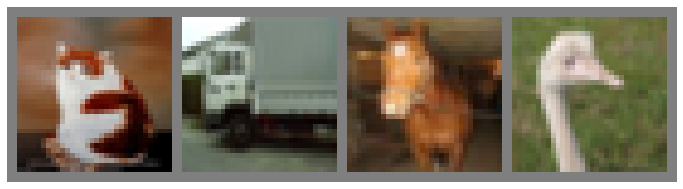

  cat truck horse  bird


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12,7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def visualizeFirstLayer(self, x):
        return self.pool(F.relu(self.conv1(x)))

net = Net()

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [33]:
loss_list = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss/2000)
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.172
[1,  4000] loss: 1.808
[1,  6000] loss: 1.673
[1,  8000] loss: 1.580
[1, 10000] loss: 1.523
[1, 12000] loss: 1.486
[2,  2000] loss: 1.410
[2,  4000] loss: 1.388
[2,  6000] loss: 1.360
[2,  8000] loss: 1.350
[2, 10000] loss: 1.300
[2, 12000] loss: 1.291
Finished Training


Plot of loss function with each 2000 mini-batch across the 2 epochs

Text(0.5, 0, 'Number of mini-batches/2000')

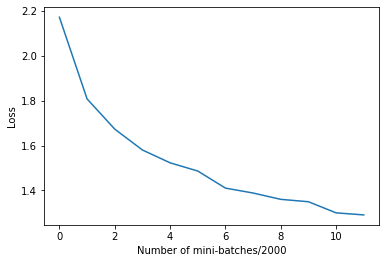

In [47]:
plt.plot(loss_list)
plt.ylabel('Loss')
plt.xlabel('Number of mini-batches/2000')

In [35]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = net(images)

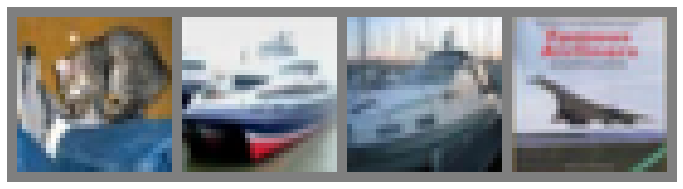

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [41]:
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [43]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data #data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [44]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 61.0 %
Accuracy for class car   is: 76.1 %
Accuracy for class bird  is: 20.0 %
Accuracy for class cat   is: 43.8 %
Accuracy for class deer  is: 65.2 %
Accuracy for class dog   is: 41.8 %
Accuracy for class frog  is: 62.0 %
Accuracy for class horse is: 51.8 %
Accuracy for class ship  is: 73.3 %
Accuracy for class truck is: 57.1 %


(v) 
Predicting the class labels of 4 sample images. 

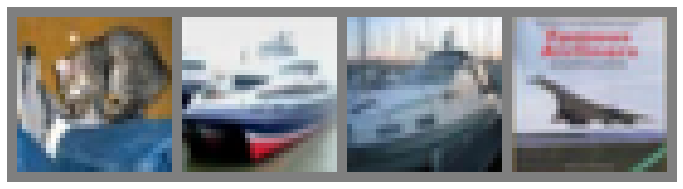

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()
layer = net.visualizeFirstLayer(images)
imshow(torchvision.utils.make_grid(images))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

(vi)\
Visualization of the output of the first layer of the network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


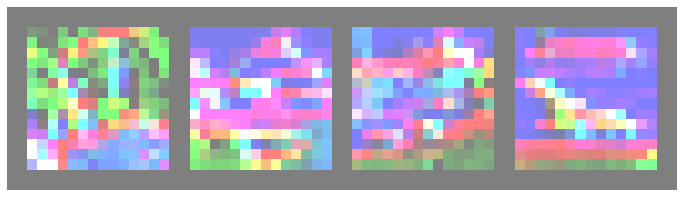

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


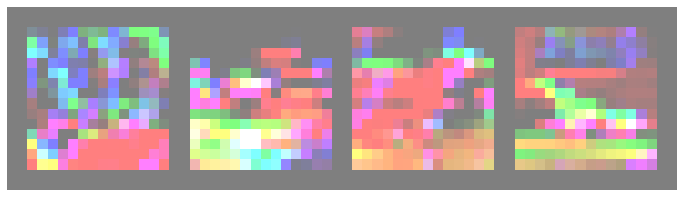

In [46]:
imshow(torchvision.utils.make_grid(layer[:,0:3,:,:]))
imshow(torchvision.utils.make_grid(layer[:,3:6,:,:]))